# Setup & Imports

In [1554]:
import json
import requests
from lxml import html
from collections import OrderedDict
import argparse
import re
import dateutil.parser
import pandas as pd
import time
from textatistic import Textatistic
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error 
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection

%matplotlib inline


# Read in data:
* article data scraped from all followers & followees of Jonathan Morgan
* User metadata from user home pages

In [1555]:
#df = pd.read_pickle('jonathonmorgan_articles_df.pkl')
df = pd.read_pickle('pickles/jonathonmorgan_articles_with_tags_df_combo.pkl')

In [1556]:
users_dict = pd.read_pickle('pickles/jonathonmorgan_master_people.pkl')
users = pd.DataFrame.from_dict(users_dict).T

users.reset_index(level=0, inplace=True)
users.rename(columns = {'index':'author'},inplace = True)

## Read in user data and change number formatting to account for 'K' and 'M' annotations

In [1557]:
#fix the 'K's in the data
followers_num = []
leaders_num = []

def fix_K_or_M(to_list, from_series):
    for n in from_series:
        if ' Follower' in str(n):
            n = re.sub(' Follower','',n)
            to_list.append(int(n))
        elif 'K' in str(n):
            n = re.sub('K','',n)
            n = float(n) * 1000
            to_list.append(int(n))
        elif 'M' in str(n):
            n = re.sub('M','',n)
            n = float(n) * 1000000
            to_list.append(int(n))
        else: 
            n = float(n)
            to_list.append(int(n))

fix_K_or_M(followers_num,users['followers'])
fix_K_or_M(leaders_num,users['leaders'])

users['followers_num'] = followers_num
users['leaders_num'] = leaders_num

users = users.drop(columns = ['followers']);
users = users.drop(columns = ['leaders']);

users.head()

,author,name,followers_num,leaders_num
0,https://medium.com/@243,243,9,52
1,https://medium.com/@2kdei,Kristina Dei,1200,2300
2,https://medium.com/@7piliers,Brendan McDonald,6600,9000
3,https://medium.com/@AJKnuppe,Austin Knuppe,49,519
4,https://medium.com/@ATXTechRecruitr,Antonio Busalacchi,51,238


In [1558]:
len(df)

3778

# Clean the data

* Evaluate Nans in dataset - confirmed that Nans were valid and dropped missing data
* Fix numeric issues with 'K' and "M' for thousands and millions
* Change column types to int/float and make datetime derivatives

## Evaluate Nans in data & drop rows with Nan

In [1559]:
count_nan = len(df) - df.count()
count_nan

url               0
author           11
claps             0
datetime         11
flesch           18
images            0
language          0
polarity          0
publisher         0
reading_time    360
sentences         0
subjectivity      0
tags              0
words             0
dtype: int64

In [1560]:
df_m = df.dropna()
df_m.shape

(3401, 14)

## Clean the existing data columns

In [1561]:
df_m.dtypes

url             object
author          object
claps           object
datetime        object
flesch          object
images          object
language        object
polarity        object
publisher       object
reading_time    object
sentences       object
subjectivity    object
tags            object
words           object
dtype: object

In [1562]:
# drop languages besides english
df_m = df_m[df_m['language'] == 'en']
df_m = df_m.drop(columns = ['language']);
df_m.shape

(3243, 13)

In [1563]:
#fix claps with a 'K' to be in thousands
claps_num = []

for clap in df_m['claps']:
    if 'K' in str(clap):
        clap = re.sub('K','',clap)
        clap = float(clap) * 1000
        claps_num.append(clap)
    else: 
        clap = float(clap)
        claps_num.append(clap)

df_m['claps_num'] = claps_num
df_m = df_m.drop(columns = ['claps']);

In [1564]:
# fix reading_time variable

article_reading_time = []

for time in df_m['reading_time']:
    if 'min read' in str(time):
        time = re.sub('min read','',time)
        time = int(time)
        article_reading_time.append(time)
    else: 
        time = int(time)
        article_reading_time.append(time)

df_m['article_reading_time'] = article_reading_time
df_m = df_m.drop(columns = ['reading_time']);

In [1565]:
# fix sentences and words to be integers
df_m['sentences'] = df_m.sentences.astype(int)
df_m['words'] = df_m.words.astype(int)
df_m['publisher'] = df_m.publisher.astype(int)
df_m['flesch'] = df_m.flesch.astype(float)
df_m['polarity'] = df_m.polarity.astype(float)
df_m['subjectivity'] = df_m.subjectivity.astype(float)
df_m['claps_num'] = df_m.claps_num.astype(int)
df_m['images'] = df_m.images.astype(int)

In [1566]:
#get rid of negative flesch scores
df_m = df_m[df_m['flesch'] >= 0 ]
df_m = df_m[df_m['flesch'] <100 ]

In [1567]:
#fix datetime variable and derive other ones

fixed_datetime = []
for datetime in df_m['datetime']:
    datetime = datetime[:-5]
    datetime = re.sub('T',' ',datetime)
    fixed_datetime.append(datetime)
    
df_m['datetime_full'] = fixed_datetime
df_m['datetime_full'] =  pd.to_datetime(df_m['datetime_full'], format='%Y-%m-%d %H:%M:%S')

df_m = df_m.drop(columns = ['datetime'])

df_m['year'] = df_m['datetime_full'].dt.year.astype(int)
df_m['hour'] = df_m['datetime_full'].dt.hour.astype(int)
df_m['day_of_week'] = df_m['datetime_full'].dt.weekday.astype(int)
df_m = df_m.drop(columns = ['datetime_full']);



# Working with tags
Make tags lists workable dummy variables & append to dataframe

In [1568]:
#create a column for the number of tags
num_tags = []
for tags in df_m['tags']:
    num_tags.append(len(tags))
num_tags

df_m['num_tags'] = num_tags

In [1569]:
#create a dicitonary of all the tags
d = {}
for t in df_m['tags']:
    for i in t:
        d[i] = d.get(i,0) + 1

In [1570]:
#toss out tags with a count of 1 or 2
d_top = { k:v for k, v in d.items() if v > 46 }

In [1571]:
#loop through each row in the original dataframe, and make a dictionary of the tags & counts
#basically all possible tags, with a 0 or 1

def get_tags_dict(df):
    tags_dict = {}
    i = 0
    for row in df['tags']:
        row_dict = {}
        for key, value in d_top.items():
            if key in row:
                row_dict[key] = 1
            else:
                row_dict[key] = 0
        tags_dict.update({i : row_dict})
        i +=1
    return tags_dict

tags_dict = get_tags_dict(df_m)

df_tags = pd.DataFrame.from_dict(tags_dict).T

In [1572]:
df_m = df_m.drop(columns = ['tags']);

In [1573]:
#add tags to the dataframe
df_total = df_m.join(df_tags)

# Merge in user metadata df

In [1574]:
total = users.merge(df_total,left_on='author',right_on='author',how = 'inner')

In [1575]:
total.head()

,author,name,followers_num,leaders_num,url,flesch,images,polarity,publisher,sentences,...,Productivity,Programming,Python,Social Media,Software Development,Sports,Startup,Tech,Technology,UX
0,https://medium.com/@243,243,9,52,https://medium.com/@243/entity-framework-the-v...,80.362968,0,0.095823,1,38,...,0,0,0,0,0,0,0,0,0,0
1,https://medium.com/@243,243,9,52,https://medium.com/@243/the-value-12-31-0000-1...,86.664919,1,0.069159,1,52,...,0,0,0,0,0,0,0,0,0,0
2,https://medium.com/@243,243,9,52,https://medium.com/@243/why-entity-framework-i...,68.711303,0,0.130187,1,56,...,0,0,0,0,0,0,0,0,0,0
3,https://medium.com/@243,243,9,52,https://medium.com/@243/why-entity-framework-i...,73.889110,0,0.030837,1,34,...,0,0,0,0,0,0,0,0,0,0
4,https://medium.com/@243,243,9,52,https://medium.com/@243/why-entity-framework-i...,77.622515,0,0.236793,1,53,...,0,0,0,0,0,0,0,0,0,0


In [1576]:
# remove @MediumStaff and @Medium - too many followers, and not really a true account
total = total[(total['author'] != 'https://medium.com/@MediumStaff')&(total['author'] != 'https://medium.com/@Medium')  &(total['author'] != 'https://medium.com/@jonahlupton') & (total['author'] != 'https://medium.com/@anildash') & (total['url'] != 'https://medium.com/@kallunalovegood/new-years-here-we-galapagos-2012-2013-bee5e5dfcba4')].sort_values('followers_num', ascending = False)


In [1577]:
#move url column over to make thigs easier
cols = total.columns.tolist()
cols = cols[:2] + cols[4:5] + cols[2:4] + cols[5:]
total = total[cols]


# Initial EDA & plotting

## Box cox skewed variables & examine results


In [1578]:
def print_columns(df):
    i = 0
    for c in df.columns:
        print (str(i)+ ' '+ c)
        i +=1

In [1579]:
list(total.columns)[10:20]

['subjectivity',
 'words',
 'claps_num',
 'article_reading_time',
 'year',
 'hour',
 'day_of_week',
 'num_tags',
 '2016 Election',
 'AI']

Text(0.5,1,'article_reading_time')

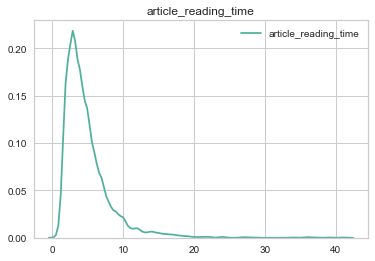

In [1580]:
#kde used to evaluate variables for transformaiton
sns.kdeplot(total['article_reading_time'], color = '#50B0A0').set_title('article_reading_time')


### Standard Scalar, then boxcox

In [1581]:
scaler = StandardScaler()
scaler.fit(total[['claps_num']])
scaler_output = (scaler.transform(total[['claps_num']]))
total['claps_scalar'] = scaler_output

In [1582]:
# sns.kdeplot(total['claps_scalar'], color = '#50B0A0').set_title('claps_scalar')

In [1583]:
# try a robust scalar
robustscaler = RobustScaler()
robustscaler.fit(total[['claps_num']])
robustscaler_output = (robustscaler.transform(total[['claps_num']]))
total['claps_robust_scalar'] = robustscaler_output



In [1584]:
total['claps_scalar_boxcox'] = stats.boxcox((total['claps_scalar']+1))[0]
total['claps_robust_boxcox'] = stats.boxcox((total['claps_robust_scalar']+1))[0]

In [1585]:
total['claps_boxcox'] = stats.boxcox((total['claps_num']+1))[0]
total['leaders_boxcox'] = stats.boxcox((total['leaders_num']+1))[0]
total['followers_boxcox'] = stats.boxcox((total['followers_num']+1))[0]
total['article_reading_time_boxcox'] = stats.boxcox((total['article_reading_time']))[0]
total['words_boxcox'] = stats.boxcox((total['words']))[0]
total['sentences_boxcox'] = stats.boxcox((total['sentences']))[0]
total['images_boxcox'] = stats.boxcox((total['images'])+1)[0]

In [1586]:
# #to get the lambda run this
# _, lmb= stats.boxcox((total['claps_num']+1))
# lmb

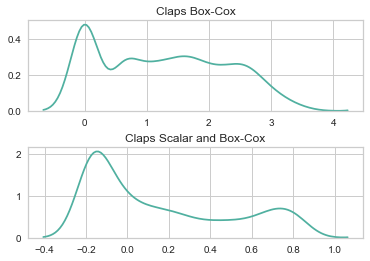

In [1587]:
plt.subplots_adjust(wspace = 0.2,hspace = 0.4 )
plt.subplot(2, 1, 1)
sns.kdeplot(total['claps_boxcox'], color = '#50B0A0', legend = False).set_title('Claps Box-Cox')
plt.subplot(2, 1, 2)
ax2 = sns.kdeplot(total['claps_robust_boxcox'], color = '#50B0A0',legend = False).set_title('Claps Scalar and Box-Cox')


Text(0.5,1,'Images Box-Cox')

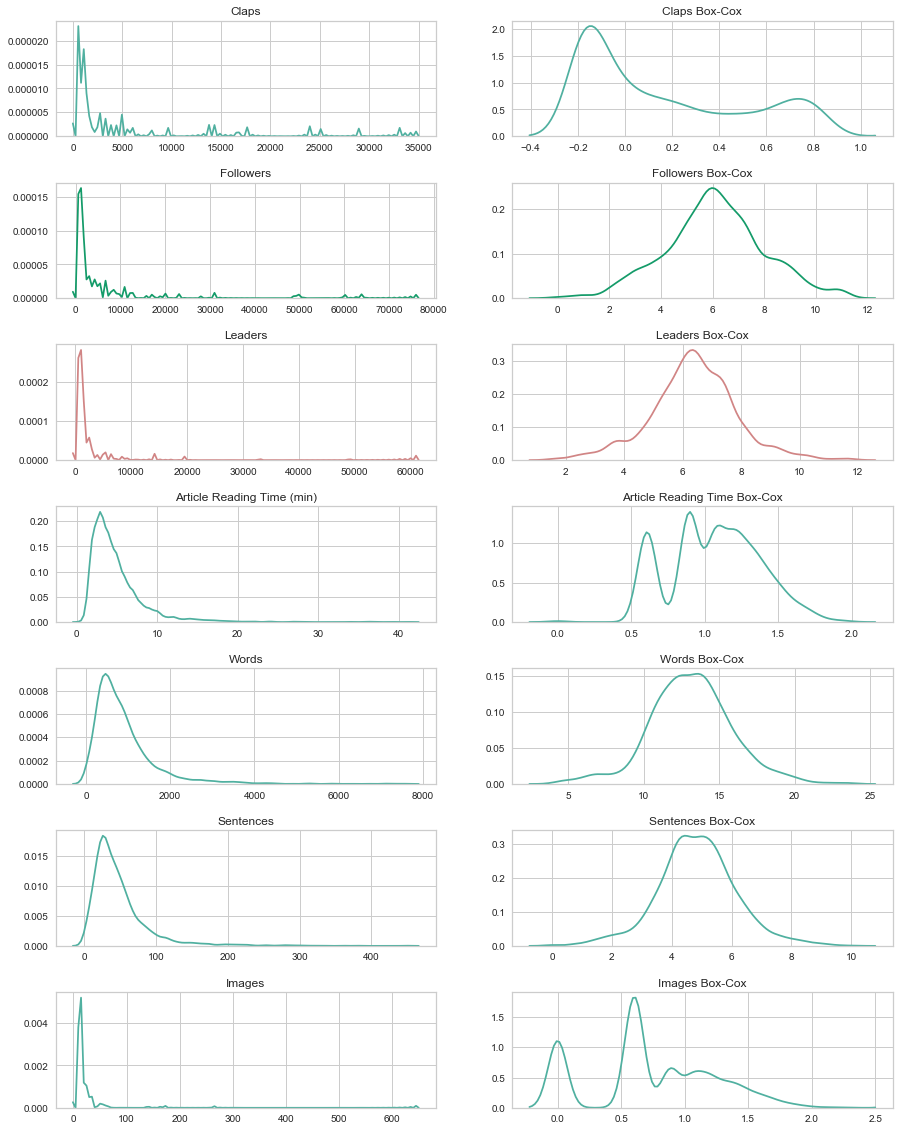

In [1588]:
fig, ax = plt.subplots(7, 2, figsize=(15,20))

plt.subplots_adjust(wspace = 0.2,hspace = 0.4 )


sns.kdeplot(total['claps_num'],ax=ax[0][0], color = '#50B0A0', legend = False).set_title('Claps')
sns.kdeplot(total['claps_robust_boxcox'],ax=ax[0][1], color = '#50B0A0',legend = False).set_title('Claps Box-Cox')

sns.kdeplot(total['followers_num'],ax=ax[1][0], color = '#149B69',legend = False).set_title('Followers')
sns.kdeplot(total['followers_boxcox'],ax=ax[1][1], color = '#149B69',legend = False).set_title('Followers Box-Cox')

sns.kdeplot(total['leaders_num'],ax=ax[2][0], color = '#D18585',legend = False).set_title('Leaders')
sns.kdeplot(total['leaders_boxcox'],ax=ax[2][1], color = '#D18585',legend = False).set_title('Leaders Box-Cox')

sns.kdeplot(total['article_reading_time'],ax=ax[3][0], color = '#50B0A0',legend = False).set_title('Article Reading Time (min)')
sns.kdeplot(total['article_reading_time_boxcox'],ax=ax[3][1], color = '#50B0A0',legend = False).set_title('Article Reading Time Box-Cox')

sns.kdeplot(total['words'],ax=ax[4][0], color = '#50B0A0',legend = False).set_title('Words')
sns.kdeplot(total['words_boxcox'],ax=ax[4][1], color = '#50B0A0',legend = False).set_title('Words Box-Cox')

sns.kdeplot(total['sentences'],ax=ax[5][0], color = '#50B0A0',legend = False).set_title('Sentences')
sns.kdeplot(total['sentences_boxcox'],ax=ax[5][1], color = '#50B0A0',legend = False).set_title('Sentences Box-Cox')

sns.kdeplot(total['images'],ax=ax[6][0], color = '#50B0A0',legend = False).set_title('Images')
sns.kdeplot(total['images_boxcox'],ax=ax[6][1], color = '#50B0A0',legend = False).set_title('Images Box-Cox')




## Plot relationships after box-cox

In [1589]:
# fit.resid.plot(style='o', figsize=(12,8), colormap = 'cool');

In [1596]:
list(total.columns)

['author',
 'name',
 'url',
 'followers_num',
 'leaders_num',
 'flesch',
 'images',
 'polarity',
 'publisher',
 'sentences',
 'subjectivity',
 'words',
 'claps_num',
 'article_reading_time',
 'year',
 'hour',
 'day_of_week',
 'num_tags',
 '2016 Election',
 'AI',
 'Artificial Intelligence',
 'Big Data',
 'Bots',
 'Business',
 'Data',
 'Data Science',
 'Data Visualization',
 'Design',
 'Donald Trump',
 'Education',
 'Entrepreneurship',
 'Government',
 'Health',
 'Journalism',
 'Life',
 'Life Lessons',
 'Machine Learning',
 'Marketing',
 'Open Data',
 'Politics',
 'Product Management',
 'Productivity',
 'Programming',
 'Python',
 'Social Media',
 'Software Development',
 'Sports',
 'Startup',
 'Tech',
 'Technology',
 'UX',
 'claps_scalar',
 'claps_robust_scalar',
 'claps_scalar_boxcox',
 'claps_robust_boxcox',
 'claps_boxcox',
 'leaders_boxcox',
 'followers_boxcox',
 'article_reading_time_boxcox',
 'words_boxcox',
 'sentences_boxcox',
 'images_boxcox']

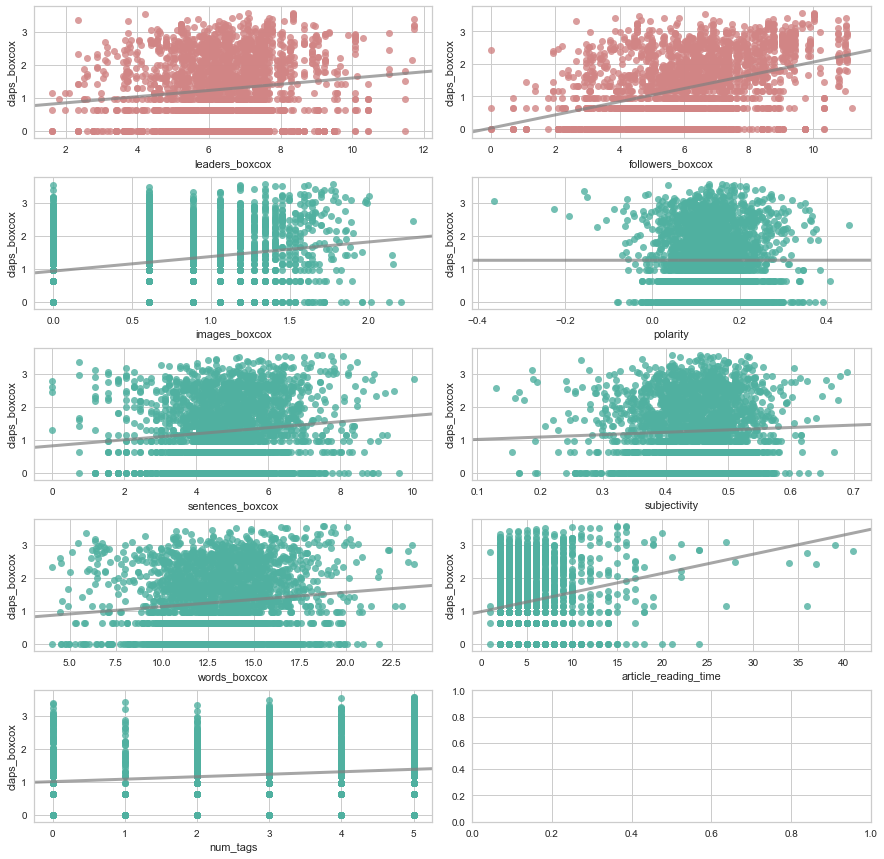

In [1597]:
fig, ax = plt.subplots(5, 2, figsize=(15,15))

plt.subplots_adjust(wspace = 0.1,hspace = 0.3 )


sns.regplot(total['leaders_boxcox'],total['claps_boxcox'],ax=ax[0][0],line_kws={'color':'grey',"alpha":0.7,"lw":3}, ci=None,color = '#D18585')
sns.regplot(total['followers_boxcox'],total['claps_boxcox'],ax=ax[0][1],line_kws={'color':'grey',"alpha":0.7,"lw":3}, ci=None,color = '#D18585')
sns.regplot(total['images_boxcox'],total['claps_boxcox'],ax=ax[1][0],line_kws={'color':'grey',"alpha":0.7,"lw":3},ci=None,color = '#50B0A0')
sns.regplot(total['polarity'],total['claps_boxcox'],ax=ax[1][1],line_kws={'color':'grey',"alpha":0.7,"lw":3},ci=None,color = '#50B0A0')
sns.regplot(total['sentences_boxcox'],total['claps_boxcox'],ax=ax[2][0],line_kws={'color':'grey',"alpha":0.7,"lw":3},ci=None,color = '#50B0A0')
sns.regplot(total['subjectivity'],total['claps_boxcox'],ax=ax[2][1],line_kws={'color':'grey',"alpha":0.7,"lw":3},ci=None,color = '#50B0A0')
sns.regplot(total['words_boxcox'],total['claps_boxcox'],ax=ax[3][0],line_kws={'color':'grey',"alpha":0.7,"lw":3},ci=None,color = '#50B0A0')
sns.regplot(total['article_reading_time'],total['claps_boxcox'],ax=ax[3][1],line_kws={'color':'grey',"alpha":0.7,"lw":3},ci=None,color = '#50B0A0')
sns.regplot(total['num_tags'],total['claps_boxcox'],ax=ax[4][0],line_kws={'color':'grey',"alpha":0.7,"lw":3},ci=None,color = '#50B0A0')







## Stupid model

In [1599]:
# quantify these relationships with a linear regression 1x1

X = total[['followers_boxcox','leaders_boxcox', 'images_boxcox', 'publisher', 'article_reading_time', 'subjectivity', 'num_tags' ]]
y = total['claps_boxcox'] 


X = sm.add_constant(X)

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           claps_boxcox   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     124.2
Date:                Wed, 25 Apr 2018   Prob (F-statistic):          6.60e-158
Time:                        19:52:22   Log-Likelihood:                -3362.5
No. Observations:                2616   AIC:                             6741.
Df Residuals:                    2608   BIC:                             6788.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4548      0.147     -3.088      0.002      -0.744      -0.166
followers_boxcox         0.2972      0.013     22.905      0.000       0.272       0.323
leaders_boxcox          -0.1840      0.017    -10.908      0.000      -0.217      -0.151
images_boxcox            0.2838      0.037      7.724      0.000       0.212       0.356
publisher                0.0875      0.039      2.247      0.025       0.011       0.164
article_reading_time     0.0304      0.005      5.890      0.000       0.020       0.041
subjectivity             0.9835      0.255      3.861      0.000       0.484       1.483
num_tags                 0.0618      0.010      5.984      0.000       0.042       0.082
==============================================================================
Omnibus:                       63.454   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.715
Skew:                           0.122   Prob(JB):                     1.07e-08
Kurtosis:                       2.473   Cond. No.                         183.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

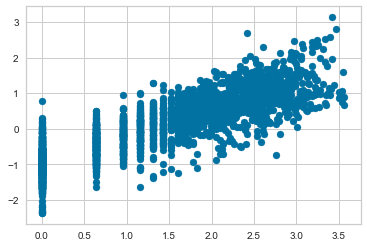

In [1600]:
plt.scatter(y, model.resid)

In [1602]:
print_columns(total)

0 author
1 name
2 url
3 followers_num
4 leaders_num
5 flesch
6 images
7 polarity
8 publisher
9 sentences
10 subjectivity
11 words
12 claps_num
13 article_reading_time
14 year
15 hour
16 day_of_week
17 num_tags
18 2016 Election
19 AI
20 Artificial Intelligence
21 Big Data
22 Bots
23 Business
24 Data
25 Data Science
26 Data Visualization
27 Design
28 Donald Trump
29 Education
30 Entrepreneurship
31 Government
32 Health
33 Journalism
34 Life
35 Life Lessons
36 Machine Learning
37 Marketing
38 Open Data
39 Politics
40 Product Management
41 Productivity
42 Programming
43 Python
44 Social Media
45 Software Development
46 Sports
47 Startup
48 Tech
49 Technology
50 UX
51 claps_scalar
52 claps_robust_scalar
53 claps_scalar_boxcox
54 claps_robust_boxcox
55 claps_boxcox
56 leaders_boxcox
57 followers_boxcox
58 article_reading_time_boxcox
59 words_boxcox
60 sentences_boxcox
61 images_boxcox


# Iterate through transformations & tests

In [1594]:
# print_columns(total)

In [1603]:
# make map that excludes tags
df_heatmap = total.iloc[:, np.r_[3:18,53,54]]

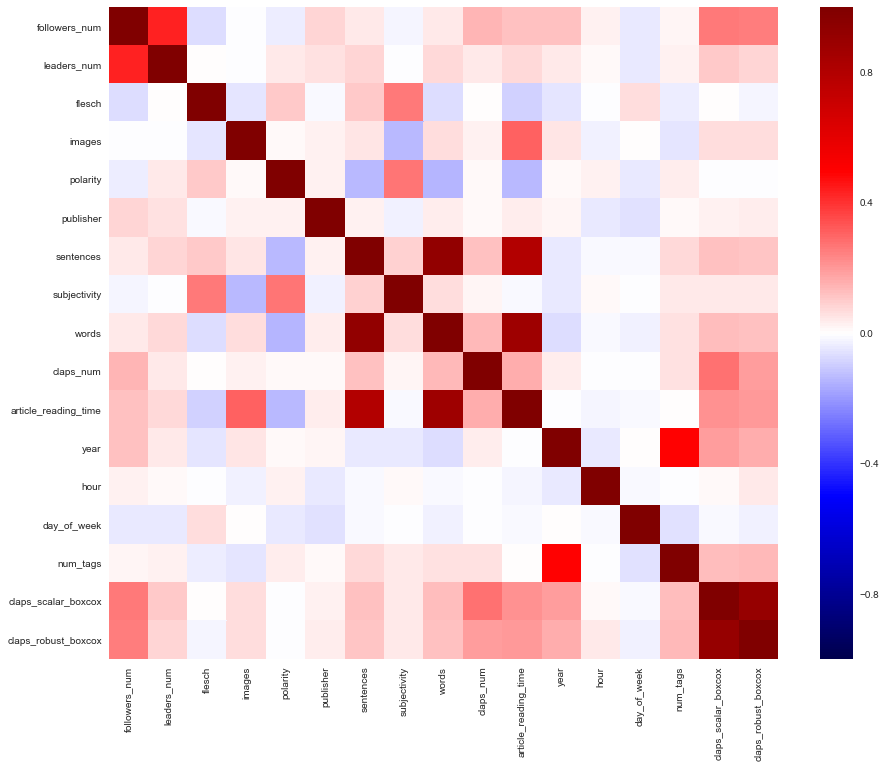

In [1604]:
plt.rcParams['figure.figsize'] = [15, 12]
sns.heatmap(df_heatmap.corr(), vmin=-1, vmax =1, cmap = 'seismic')

## Model with polynomial and ElasticNetCV

In [1606]:
X = total.iloc[:, np.r_[5,7:12,13:51,56:58,61]]

y = total.iloc[:,53]

In [1611]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 2) 

In [1612]:
l1rat = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
alphas = [.01,.1,1,1e2,15,20,50,1e3]
degree = 2
est = make_pipeline(PolynomialFeatures(2), ElasticNetCV(l1_ratio = l1rat, alphas = alphas, cv = 5))
est.fit(X_train, y_train)
rmse = np.sqrt(mean_squared_error(y_test, est.predict(X_test)))
print(est.score(X_train, y_train),est.score(X_test,y_test), rmse)


0.24400248340474573 0.25996156825226424 0.08790140952235102


In [1440]:
#run a for loop to select the base claps transformation
claps_var = [53,54,55]
for i in claps_var:
    X = total.iloc[:, np.r_[5,7:12,13:51,52:54,57]]
    y = total.iloc[:,i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    l1rat = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
    alphas = [.01,.1,1,1e2,15,20,50,1e3]
    degree = 2
    est = make_pipeline(PolynomialFeatures(2), ElasticNetCV(l1_ratio = l1rat, alphas = alphas, cv = 5))
    est.fit(X_train, y_train)
    rmse = np.sqrt(mean_squared_error(y_test, est.predict(X_test)))
    print("alpha =", est.named_steps.elasticnetcv.alpha_, "l1_ratio =",
      est.named_steps.elasticnetcv.l1_ratio_)
    print(i,est.score(X_train, y_train),est.score(X_test,y_test), rmse)
    
    

51 0.2602111261060903 0.2541898676392218 0.8740792697128418
60 0.2421983129305506 0.23332706082894092 0.08645682594969319
62 0.25141142115813186 0.272447686260461 0.287609201646728


* 51 claps_boxcox
* 60 claps_scalar_boxcox
* 62 claps_robust_boxcox

Results:
- 51 0.2602111261060903, 0.2541898676392218, 0.8740792697128418
- 60 0.2421983129305506, 0.23332706082894092, 0.08645682594969319
- 62 0.25141142115813186, 0.272447686260461, 0.287609201646728


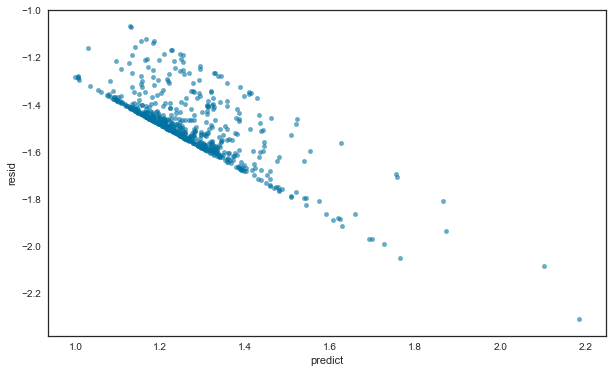

In [1444]:
data = pd.DataFrame(y_test)
data['predict']=fit.predict(X_test)
data['resid']=data.claps_scalar_boxcox-data.predict
with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.6,figsize=(10,6))

## Create 2nd degree poly features

In [ ]:
#run plynomial
poly = (PolynomialFeatures(2))
ply_df = pd.DataFrame(poly.fit_transform(X))
ply_df.columns = poly.get_feature_names(X.columns)

In [ ]:
ply_df = ply_df.join(y)

In [ ]:
list(poly_df.columns)[-5:]

## crate train/test split with the new polynomial dataset

In [ ]:
#create a new X and y from this polynomial training df
X_poly = ply_df.iloc[:,:-1 ]

#52 = log_claps, 12 claps_num 
y_poly = ply_df['claps_boxcox']

In [ ]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y_poly, test_size=0.25) 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

In [ ]:
len(y_train)

## Loop through Lasso & ElasticNet models

note this currently isn't working with the polynomial set

In [ ]:
ENmodel = ElasticNet(1.0, l1_ratio = 0.6)
fit = ENmodel.fit(X_train, y_train)
print(ENmodel.score(X_train, y_train))
print(ENmodel.score(X_test,y_test))

In [ ]:
#loop through alphas in lasso to find the best fit
import warnings
warnings.filterwarnings("ignore")

alphas = np.logspace(1, 8.0, num=10,base=2.0)
scores = np.empty_like(alphas)
for i,a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    scores[i] = lasso.score(X_test, y_test)
    print(a,  scores[i])

In [ ]:
model = Lasso(12.699)
fit = model.fit(X_train, y_train)
preds = fit.predict(X_test)
error = np.sqrt(MSE(preds,y_test))
print(error)
print(model.score(X_test,y_test))

In [ ]:
lasso = Lasso(12.699)
visualizer = ResidualsPlot(lasso)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

In [ ]:
# model = ElasticNetCV(fit_intercept=True,  alphas=[0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.])
# model.fit(X_train, y_train)
# print(model.score(X_train, y_train), model.score(X_test, y_test))

In [ ]:
# poly = est.steps[0][1]
# lr.coef_
# len(poly.get_feature_names())

# Make some more descriptive plots

In [ ]:
#  list(total.columns)

In [1306]:
#work with a test dataset so I don't mess up earlier parts
test = total

In [1307]:
article_reading_time_categories = []
for num in test["article_reading_time"]:
    if num <= 5:
        article_reading_time_categories.append('1-5 min')
    elif 5 < num <=10:
        article_reading_time_categories.append('5-10 min')
    elif 10 < num <=15:
        article_reading_time_categories.append('10-15 min')
    elif 15 < num <=20:
        article_reading_time_categories.append('15-20 min')
    elif 20 < num <=25:
        article_reading_time_categories.append('20-25 min')
    elif 25 < num <=30:
        article_reading_time_categories.append('25-30 min')
    elif num > 30:
        article_reading_time_categories.append('30+ min')
article_reading_time_categories

test['article_reading_time_categories'] = article_reading_time_categories
        
        

In [1308]:
#create one just to look at the data science tag
ds = test[(test['Data Science'] == 1)]

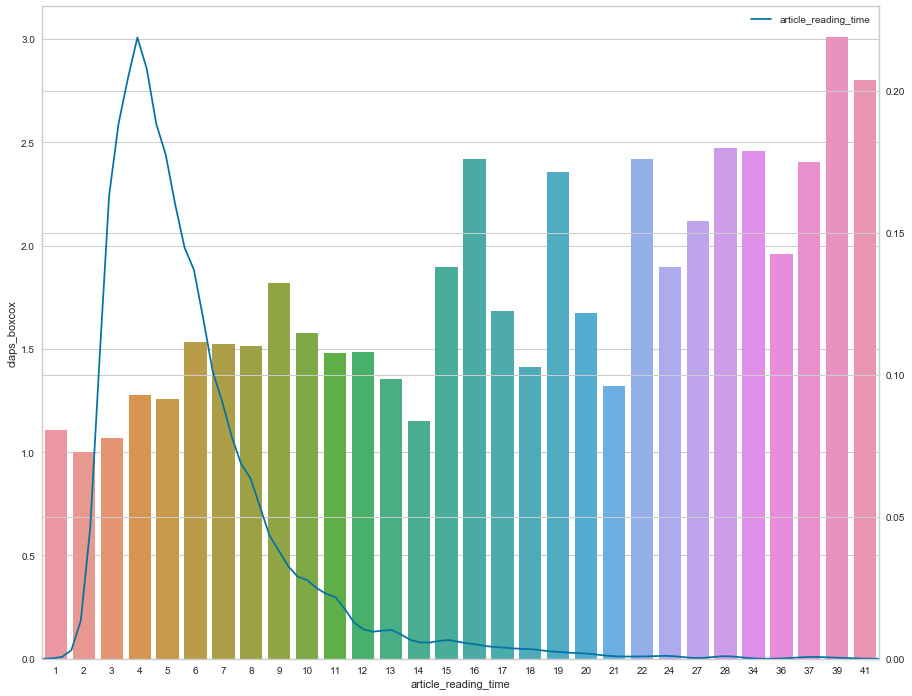

In [1315]:
plt.rcParams['figure.figsize'] = [15, 12]

fig, ax = plt.subplots()

ax2 =ax.twinx()
sns.barplot(x="article_reading_time", y="claps_boxcox", data=test,estimator=np.mean, ci= None, ax = ax)
sns.kdeplot(test["article_reading_time"], ax = ax2)
    
    

In [1310]:
# fig, ax = plt.subplots()
# ax2 =ax.twinx()
# sns.barplot(x="article_reading_time_categories", y="claps_num", data=test,estimator=np.mean, ci= None, ax = ax)
# sns.kdeplot(test["article_reading_time"], ax = ax2)

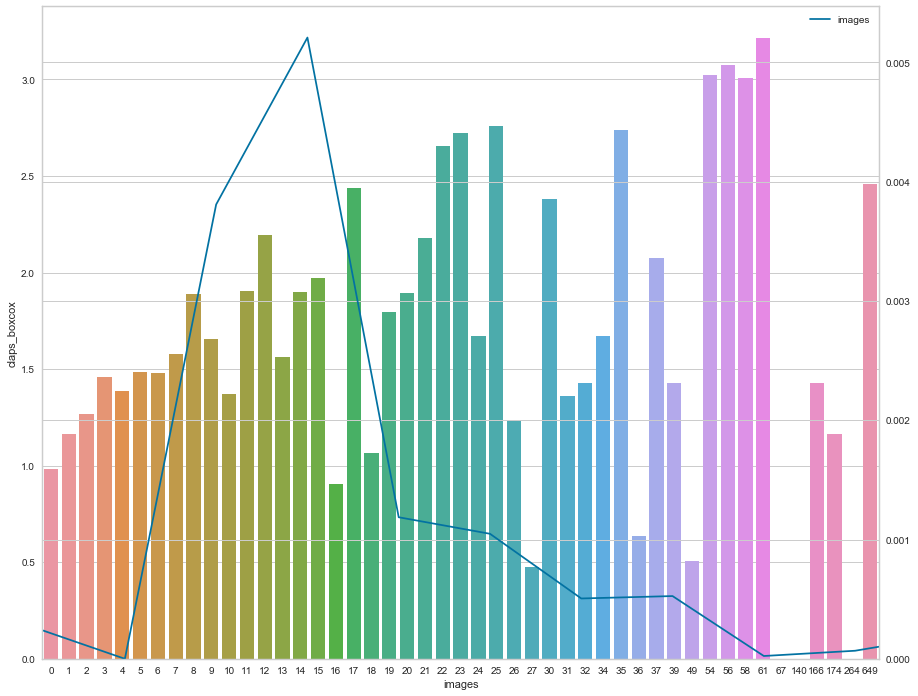

In [1311]:
fig, ax = plt.subplots()
ax2 =ax.twinx()
sns.barplot(x="images", y="claps_boxcox",data=test,estimator=np.mean, ci= None, ax = ax)
sns.kdeplot(test["images"], ax = ax2)


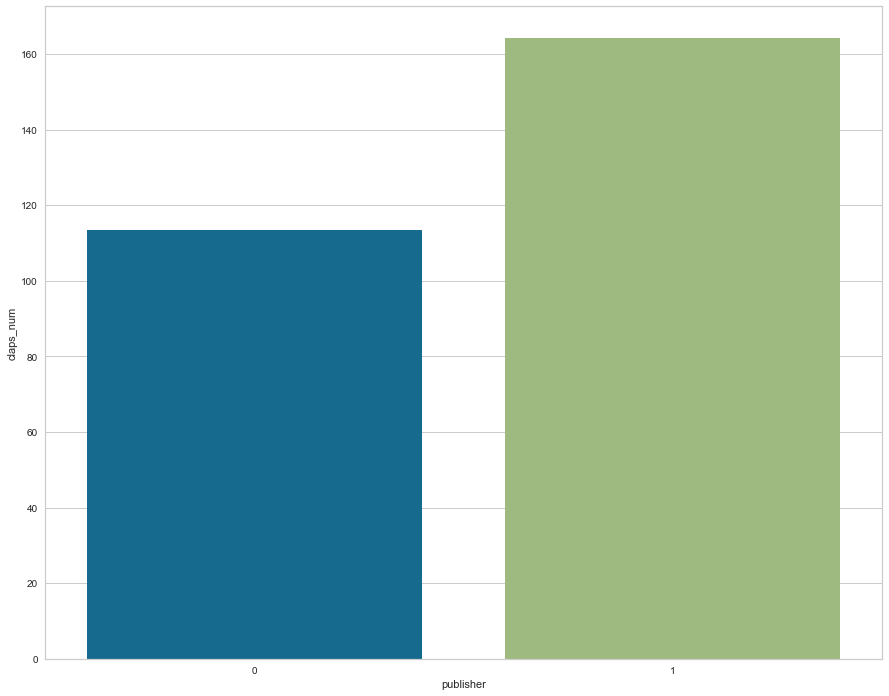

In [1312]:
fig, ax = plt.subplots()
sns.barplot(x="publisher", y="claps_num", data=test,estimator=np.mean, ci= None, ax = ax)


In [1318]:
# has_pub = list(test[test['publisher'] ==1]['claps_num'])
# no_pub =  list(test[test['publisher'] ==0]['claps_num'])

has_pub = list(test[test['publisher'] ==1]['claps_boxcox'])
no_pub =  list(test[test['publisher'] ==0]['claps_boxcox'])

In [1319]:
#check signif between groups
stats.f_oneway(has_pub,no_pub)

F_onewayResult(statistic=5.575508911741744, pvalue=0.018286354789736864)

In [ ]:
# total.groupby(['article_reading_time']).agg("median")['claps_num']

## get claps per tag

In [ ]:
# print_columns(tags_test)

In [ ]:
tags_test.head()

In [ ]:
tags_test= test.iloc[:,np.r_[18:52]]

In [ ]:
group_columns = list(tags_test.iloc[:,:33].columns)

In [ ]:
tags_test.group_by[group_columns]